In [1]:
import os, sys
import matplotlib.pyplot as plt
import warnings, joblib

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

warnings.filterwarnings("ignore")

In [2]:
project_root = os.path.abspath(os.path.join("..", "scraper"))
sys.path.insert(0, project_root)
from utils import *

In [3]:
# Connect to the AWS database
connection, cursor = database_connection_and_cursor()
cursor.execute(
    """SELECT * FROM hltv_cs"""
)
cs_data = cursor.fetchall()
cols = [col[0] for col in cursor.description]
cs_data = pd.DataFrame(cs_data, columns=cols)
cs_data.head()

[STATUS]: SUCCESSFULLY CREATED DB CONNECTION


,match_url,event,date,map,map_number,team,team_url,opponent,opponent_url,player_name,...,opponent_score,kills,headshots,assists,deaths,kast,k_d_diff,adr,fk_diff,rating
0,https://www.hltv.org/stats/matches/101558/meti...,Betswap Winter Cup 2023,2023-12-30,Inferno,1,The Witchers,https://www.hltv.org/stats/teams/12183/the-wit...,Metizport,https://www.hltv.org/stats/teams/11641/metizport,smooya,...,9,21,8,3,10,95.50,11,91.30,2,1.45
1,https://www.hltv.org/stats/matches/101558/meti...,Betswap Winter Cup 2023,2023-12-30,Vertigo,2,The Witchers,https://www.hltv.org/stats/teams/12183/the-wit...,Metizport,https://www.hltv.org/stats/teams/11641/metizport,smooya,...,6,19,10,7,10,89.50,9,106.40,2,1.70
2,https://www.hltv.org/stats/matches/101558/meti...,Betswap Winter Cup 2023,2023-12-30,Inferno,1,Metizport,https://www.hltv.org/stats/teams/11641/metizport,The Witchers,https://www.hltv.org/stats/teams/12183/the-wit...,Jackinho,...,13,16,6,1,14,77.30,2,66.40,3,1.03
3,https://www.hltv.org/stats/matches/101558/meti...,Betswap Winter Cup 2023,2023-12-30,Vertigo,2,Metizport,https://www.hltv.org/stats/teams/11641/metizport,The Witchers,https://www.hltv.org/stats/teams/12183/the-wit...,Jackinho,...,13,11,5,2,17,57.90,-6,54.00,-1,0.75
4,https://www.hltv.org/stats/matches/101558/meti...,Betswap Winter Cup 2023,2023-12-30,Inferno,1,Metizport,https://www.hltv.org/stats/teams/11641/metizport,The Witchers,https://www.hltv.org/stats/teams/12183/the-wit...,ztr,...,13,9,5,10,19,59.10,-10,86.50,-5,0.70


In [4]:
cs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212397 entries, 0 to 212396
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   match_url       212397 non-null  object
 1   event           212397 non-null  object
 2   date            212397 non-null  object
 3   map             212397 non-null  object
 4   map_number      212397 non-null  int64 
 5   team            212397 non-null  object
 6   team_url        212397 non-null  object
 7   opponent        212397 non-null  object
 8   opponent_url    212397 non-null  object
 9   player_name     212397 non-null  object
 10  player_url      212397 non-null  object
 11  team_score      212397 non-null  int64 
 12  opponent_score  212397 non-null  int64 
 13  kills           212397 non-null  int64 
 14  headshots       212397 non-null  int64 
 15  assists         212397 non-null  int64 
 16  deaths          212397 non-null  int64 
 17  kast            212397 non-nu

In [5]:
# Convert To Float Values
cs_data[["kast", "adr", "rating"]] = cs_data[["kast", "adr", "rating"]].astype("float")
cs_data["date"] = pd.to_datetime(cs_data["date"])

In [6]:
# Number of unique players
print(f"There's {len(cs_data['player_name'].unique())} unique players")
# Number of unique teams
print(f"There's {len(cs_data['team'].unique())} unique teams")

There's 3627 unique players
There's 982 unique teams


In [7]:
# Store the stats only as a dataframe
cs_stats = cs_data.iloc[:, :].query("(map != 'Best of 3') and (map != 'Best of 2') and (map != 'All') and (map != 'Cache')").reset_index(drop=True)
cs_stats.shape

(212057, 22)

In [8]:
# Drop the missing values
cs_stats = cs_stats.dropna().reset_index(drop=True)

In [9]:
# Describe the data
cs_stats.describe().round(3)

,date,map_number,team_score,opponent_score,kills,headshots,assists,deaths,kast,k_d_diff,adr,fk_diff,rating
count,212053,212053.000,212053.000,212053.000,212053.000,212053.000,212053.000,212053.000,212053.000,212053.000,212053.000,212053.000,212053.000
mean,2024-08-04 09:27:35.093774080,1.532,10.810,10.810,14.432,7.306,4.922,14.538,71.465,-0.106,73.456,-0.004,1.055
min,2023-12-30 00:00:00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,7.100,-25.000,0.400,-11.000,0.030
25%,2024-05-01 00:00:00,1.000,8.000,8.000,11.000,5.000,3.000,12.000,63.600,-5.000,60.100,-1.000,0.810
50%,2024-08-07 00:00:00,2.000,13.000,13.000,14.000,7.000,5.000,14.000,72.200,0.000,72.400,0.000,1.030
75%,2024-11-01 00:00:00,2.000,13.000,13.000,18.000,9.000,7.000,17.000,80.000,4.000,85.600,1.000,1.270
max,2025-02-26 00:00:00,5.000,37.000,37.000,63.000,34.000,28.000,55.000,100.000,31.000,193.500,12.000,3.330
std,NaN,0.914,3.887,3.887,5.552,3.588,2.730,4.278,12.194,5.996,19.440,2.182,0.353


In [10]:
# Filter the dataset to only matchups that include maps 1, 2, and 3
cs_stats.drop(columns=["k_d_diff", "fk_diff"], inplace=True)
df_filtered = cs_stats.groupby(by=["match_url"]).filter(lambda group: set(group["map_number"]).issubset({1, 2, 3}))
df_filtered.reset_index(drop=True, inplace=True)
df_filtered.shape

(181730, 20)

In [11]:
def total_maps(df: pd.DataFrame, three: bool=False) -> pd.DataFrame:
    """
    Totals up the statistics on the dataframe and returns a new dataframe

    Params:
        df (pd.DataFrame): The dataframe
        three_maps (bool): If it is three maps

    Returns:
        df (pd.DataFrame): New dataframe
    """
    df = df.copy()
    # Total Up Statistics
    stats = ["kills", "headshots", "assists", "deaths", "kast", "adr", "rating"]
    # Three Maps
    if three:
        for stat_column in stats:
            idx = df_filtered.columns.get_indexer([stat_column])[0]
            stat_value = df[f"{stat_column}_map_1"] + df[f"{stat_column}_map_2"] + df[f"{stat_column}_map_3"]
            if stat_column in ["kast", "k_d_diff", "adr", "fk_diff", "rating"]:
                df.insert(loc=idx, column=stat_column, value=stat_value/3)
            else:
                df.insert(loc=idx, column=stat_column, value=stat_value)
        drop_cols = [f"{stat_column}_map_1" for stat_column in stats] + [f"{stat_column}_map_2" for stat_column in stats] + [f"{stat_column}_map_3" for stat_column in stats]
        df.drop(columns=drop_cols, inplace=True)
        df["map_number"] = "MAPS 1-3"
        return df
    # Two Maps
    else:
        for stat_column in stats:
            idx = df_filtered.columns.get_indexer([stat_column])[0]
            stat_value = df[f"{stat_column}_map_1"] + df[f"{stat_column}_map_2"]
            if stat_column in ["kast", "adr", "rating"]:
                df.insert(loc=idx, column=stat_column, value=stat_value/2)
            else:
                df.insert(loc=idx, column=stat_column, value=stat_value)
        drop_cols = [f"{stat_column}_map_1" for stat_column in stats] + [f"{stat_column}_map_2" for stat_column in stats]
        df.drop(columns=drop_cols, inplace=True)
        df["map_number"] = "MAPS 1-2"
        return df

In [12]:
# Seperate the maps
map_1 = df_filtered[df_filtered["map_number"] == 1]
map_2 = df_filtered[df_filtered["map_number"] == 2]
map_3 = df_filtered[df_filtered["map_number"] == 3]

In [13]:
# Columns to use
target_cols = ["match_url", "player_url", "kills", "headshots", "assists", "deaths", "kast", "adr", "rating"]

#_map_1-2
map_1_2= pd.merge(
    left=map_1,
    right=map_2[target_cols],
    suffixes = ("_map_1", "_map_2"),
    on=["match_url", "player_url"],
)

#_map_1-3
map_1_2_3 = map_1_2.merge(
    right=map_3[target_cols],
    on=["match_url", "player_url"],
).rename(columns={"kills": "kills_map_3", "headshots": "headshots_map_3", "assists": "assists_map_3", 
                "deaths": "deaths_map_3", "kast": "kast_map_3", "adr": "adr_map_3", "rating": "rating_map_3"})

# Apply Function
map_1_2 = total_maps(df=map_1_2)
map_1_2_3 = total_maps(df=map_1_2_3, three=True)

# Rename 
map_1["map_number"] = "MAPS 1"
map_3["map_number"] = "MAPS 3"

# Full Stats
cs_data_formatted = pd.concat(
    [
        map_1,
        map_3,
        map_1_2,
        map_1_2_3
    ],
    ignore_index=True
)

In [14]:
# Drop columns
drop_cols = ["match_url", "event", "date", "map", "team", "opponent", "player_name", "team_score", "opponent_score"]
cs_ml_df = cs_data_formatted.copy()

# Look at stats before 2025 and after 2023
cs_ml_df = cs_ml_df[(cs_ml_df["date"].dt.year < 2025) & (cs_ml_df["date"].dt.year > 2023)].reset_index(drop=True)
cs_ml_df.drop(columns=drop_cols, inplace=True)

In [15]:
# Filter to players that played at least 100 matches
cs_ml_df = cs_ml_df.groupby(["player_url", "map_number"]).filter(lambda group: len(group) >= 30)
cs_ml_df.reset_index(drop=True, inplace=True)
cs_ml_df.shape

(122740, 11)

In [16]:
# Weighted moving average (weights)
weights = np.array([0.25, 0.20, 0.15, 0.125, 0.115, 0.10, 0.05, 0.01])

# Window size
n = 8

# Columns to apply weighted moving averages
weight_cols = ["kills", "headshots", "assists", "deaths", "kast", "adr", "rating"]

In [17]:
# Group by an individual and the map they played on
player_map_groups = cs_ml_df.groupby(["player_url", "map_number"])[weight_cols].rolling(n, closed="left").apply(lambda group: np.dot(weights[::-1], group), raw=True)

# Reset the index and make sure it aligns with the dataframe
player_map_groups = player_map_groups.add_prefix("wma_").reset_index().set_index("level_2").sort_index()

# Drop null values
player_map_groups.dropna(inplace=True)

In [18]:
# Merge Old Dataframe
cs_ml_df= pd.merge(
    left=cs_ml_df[["map_number", "team_url", "opponent_url", "player_url", "kills", "headshots"]],
    right=player_map_groups.drop(columns=["player_url", "map_number"]),
    left_index=True,
    right_index=True
)
cs_ml_df.reset_index(drop=True, inplace=True)
cs_ml_df.head()

,map_number,team_url,opponent_url,player_url,kills,headshots,wma_kills,wma_headshots,wma_assists,wma_deaths,wma_kast,wma_adr,wma_rating
0,MAPS 1,https://www.hltv.org/stats/teams/11668/mindfreak,https://www.hltv.org/stats/teams/9881/rooster,https://www.hltv.org/stats/players/9108/tucks,12,5,12.665,6.630,5.200,15.850,63.8540,67.049,0.89915
1,MAPS 1,https://www.hltv.org/stats/teams/11176/mouz-nxt,https://www.hltv.org/stats/teams/5996/tsm,https://www.hltv.org/stats/players/21972/neityu,11,8,13.970,8.045,6.420,13.175,80.2315,71.940,1.14000
2,MAPS 1,https://www.hltv.org/stats/teams/11176/mouz-nxt,https://www.hltv.org/stats/teams/5996/tsm,https://www.hltv.org/stats/players/21983/chr1zn,10,6,15.295,9.270,5.865,13.850,76.9490,79.451,1.25465
3,MAPS 1,https://www.hltv.org/stats/teams/11176/mouz-nxt,https://www.hltv.org/stats/teams/5996/tsm,https://www.hltv.org/stats/players/22279/pr,4,3,17.355,7.850,3.730,11.995,74.8910,86.665,1.36840
4,MAPS 1,https://www.hltv.org/stats/teams/11176/mouz-nxt,https://www.hltv.org/stats/teams/5996/tsm,https://www.hltv.org/stats/players/22695/sirah,8,4,15.290,9.415,5.785,12.840,80.3615,90.662,1.33460


In [19]:
# Count the number of unique players and teams that need to be encoded
print(f"Teams: {len(set(cs_ml_df['team_url']))}")
print(f"Players: {len(set(cs_ml_df['player_url']))}")

Teams: 294
Players: 726


In [20]:
# Map Encode
maps_encode = pd.get_dummies(cs_ml_df["map_number"], dtype="int")

In [21]:
# Teams Encoded
cursor.execute("SELECT * FROM teams_encoded")
team_mapper = cursor.fetchall()
teams_encoded_df = pd.DataFrame(team_mapper, columns=[col[0] for col in cursor.description]).set_index(["hltv_url", "map_number"])
team_mapper = teams_encoded_df.to_dict()["std"]

In [22]:
# Players Encoded
cursor.execute("SELECT * FROM players_encoded")
player_mapper = cursor.fetchall()
players_encoded_df = pd.DataFrame(player_mapper, columns=[col[0] for col in cursor.description]).set_index(["hltv_url", "map_number"])
player_mapper = players_encoded_df.to_dict()["std"]

In [23]:
player_team_mapped = cs_ml_df.apply(lambda row: team_mapper.get((row["team_url"], row["map_number"])), axis=1) 
opponent_team_mapped = cs_ml_df.apply(lambda row: team_mapper.get((row["opponent_url"], row["map_number"])), axis=1)
player_mapped = cs_ml_df.apply(lambda row: player_mapper.get((row["player_url"], row["map_number"])), axis=1) 

In [24]:
hi = teams_encoded_df.reset_index()

In [25]:
# Create the ML model with all the features
ml_model_df = pd.concat(
    [
        cs_ml_df.drop(columns=["map_number", "team_url", "opponent_url", "player_url"]),
        maps_encode.rename(columns={"MAPS 1": "map_1", "MAPS 1-2": "map_1_2", "MAPS 1-3": "map_1_3", "MAPS 3": "map_3"}),
        player_team_mapped,
        opponent_team_mapped,
        player_mapped,
    ],
    axis=1
).rename(columns={0: "player_team_enc", 1: "opponent_team_enc", 2: "player_enc"})
ml_model_df.head()

,kills,headshots,wma_kills,wma_headshots,wma_assists,wma_deaths,wma_kast,wma_adr,wma_rating,map_1,map_1_2,map_1_3,map_3,player_team_enc,opponent_team_enc,player_enc
0,12,5,12.665,6.630,5.200,15.850,63.8540,67.049,0.89915,1,0,0,0,5.164329,5.546751,5.274205
1,11,8,13.970,8.045,6.420,13.175,80.2315,71.940,1.14000,1,0,0,0,5.428260,5.606278,5.319920
2,10,6,15.295,9.270,5.865,13.850,76.9490,79.451,1.25465,1,0,0,0,5.428260,5.606278,5.105187
3,4,3,17.355,7.850,3.730,11.995,74.8910,86.665,1.36840,1,0,0,0,5.428260,5.606278,5.781659
4,8,4,15.290,9.415,5.785,12.840,80.3615,90.662,1.33460,1,0,0,0,5.428260,5.606278,5.708339


In [26]:
# Split independent and dependent variables
x = ml_model_df.drop(columns=["kills", "headshots"])
Y = ml_model_df[["kills", "headshots"]]

# Split into 90% training and 10% testing
x_train, x_test, y_train, y_test = train_test_split(x, Y, train_size=0.90, shuffle=True, random_state=42)

In [27]:
# Initalize the regression models
lr = LinearRegression()
lasso = Lasso()
dtr = DecisionTreeRegressor()
xgr = XGBRegressor()

In [28]:
def model_scores(model, x_train, y_train, x_test, y_test, boost=False):
    # Fit the model
    if boost==False:
        model.fit(x_train, y_train)
    # Make predictions on testing set
    y_pred = model.predict(x_test)
    # Scores
    r2 = r2_score(y_test, y_pred, multioutput="raw_values")
    mae = mean_absolute_error(y_test, y_pred, multioutput="raw_values")
    rmse = root_mean_squared_error(y_test, y_pred, multioutput="raw_values")
    print(f"R2 Score (Kills): {r2[0]}")
    print(f"R2 Score (Headshots): {r2[1]}")
    print(f"Mean Absolute Error (Kills): {mae[0]}")
    print(f"Mean Absolute Error (Headshots): {mae[1]}")
    print(f"Root Mean Squared Error (Kills): {rmse[0]}")
    print(f"Root Mean Squared Error (Headshots): {rmse[1]}")
    return model, r2, mae, rmse, y_pred

In [29]:
# Plot the residuals
def plot_residuals(preds, actual, model_type):
    # Make a copy of the y_test
    resi_y_test = actual.copy()

    # Store the residuals
    residuals = actual - preds

    # Put it into the dataframe
    resi_y_test[["Kills Predicted", "Headshots Predicted"]] = preds
    resi_y_test[["Kills Residuals", "Headshots Residuals"]] = residuals

    # Plot both kills and headshots
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    # Set the title for the entire figure
    fig.suptitle(model_type, fontsize=14)
    fig.set_tight_layout(tight=True)

    # Plotting the kills
    ax[0].scatter(x=resi_y_test["Kills Predicted"], y=resi_y_test["Kills Residuals"], alpha=0.10)
    ax[0].set_title("Residual Plot For Kills")
    ax[0].set_xlabel("$\hat{{y}}$")
    ax[0].axhline(0, c="r")

    # Plotting the headshots
    ax[1].scatter(x=resi_y_test["Headshots Predicted"], y=resi_y_test["Headshots Residuals"], alpha=0.10)
    ax[1].set_title("Residual Plot For Headshots")
    ax[1].set_xlabel("$\hat{{y}}$")
    ax[1].axhline(0, c="r")

R2 Score (Kills): 0.6812141345386379
R2 Score (Headshots): 0.6222454990059032
Mean Absolute Error (Kills): 5.225187404505903
Mean Absolute Error (Headshots): 3.301130993898961
Root Mean Squared Error (Kills): 6.809930457378177
Root Mean Squared Error (Headshots): 4.283558753405761


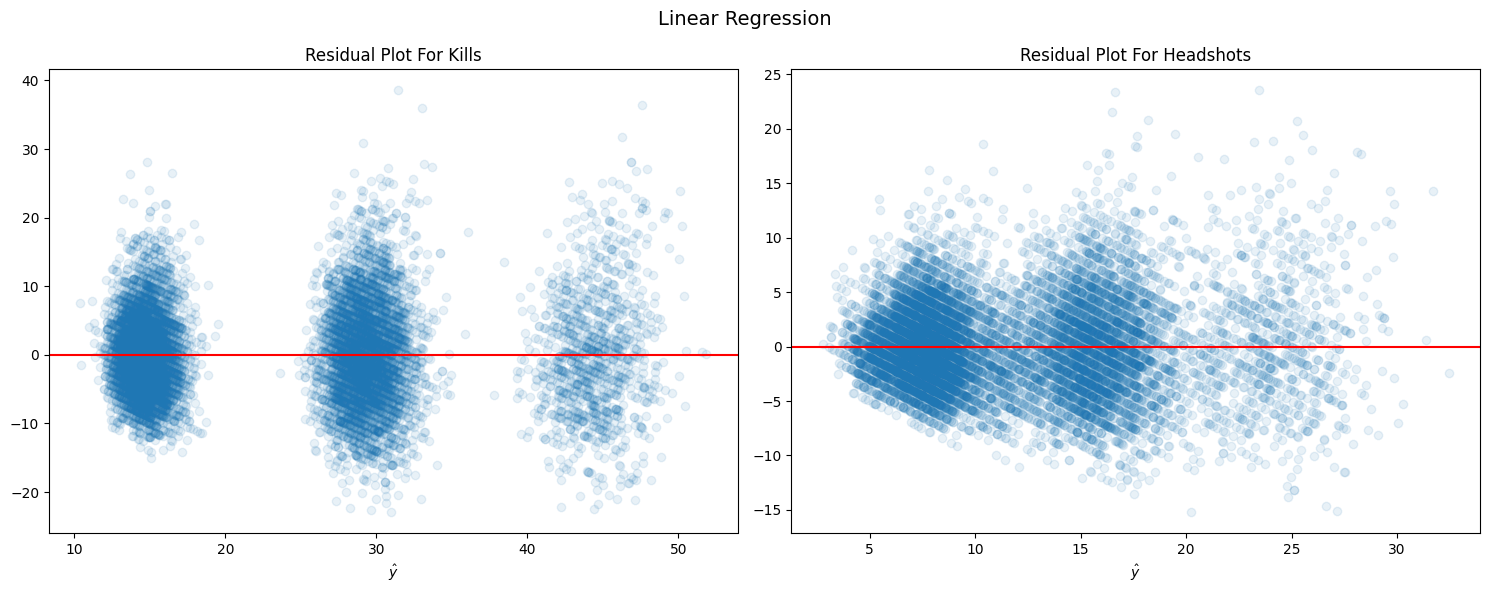

In [30]:
lr, r2, mae, rmse, y_pred_lr = model_scores(lr, x_train, y_train, x_test, y_test)
plot_residuals(y_pred_lr, y_test, "Linear Regression")

R2 Score (Kills): 0.658338763030694
R2 Score (Headshots): 0.6058949780667957
Mean Absolute Error (Kills): 5.403769295258803
Mean Absolute Error (Headshots): 3.3705937495629192
Root Mean Squared Error (Kills): 7.05003061340973
Root Mean Squared Error (Headshots): 4.375280376529393


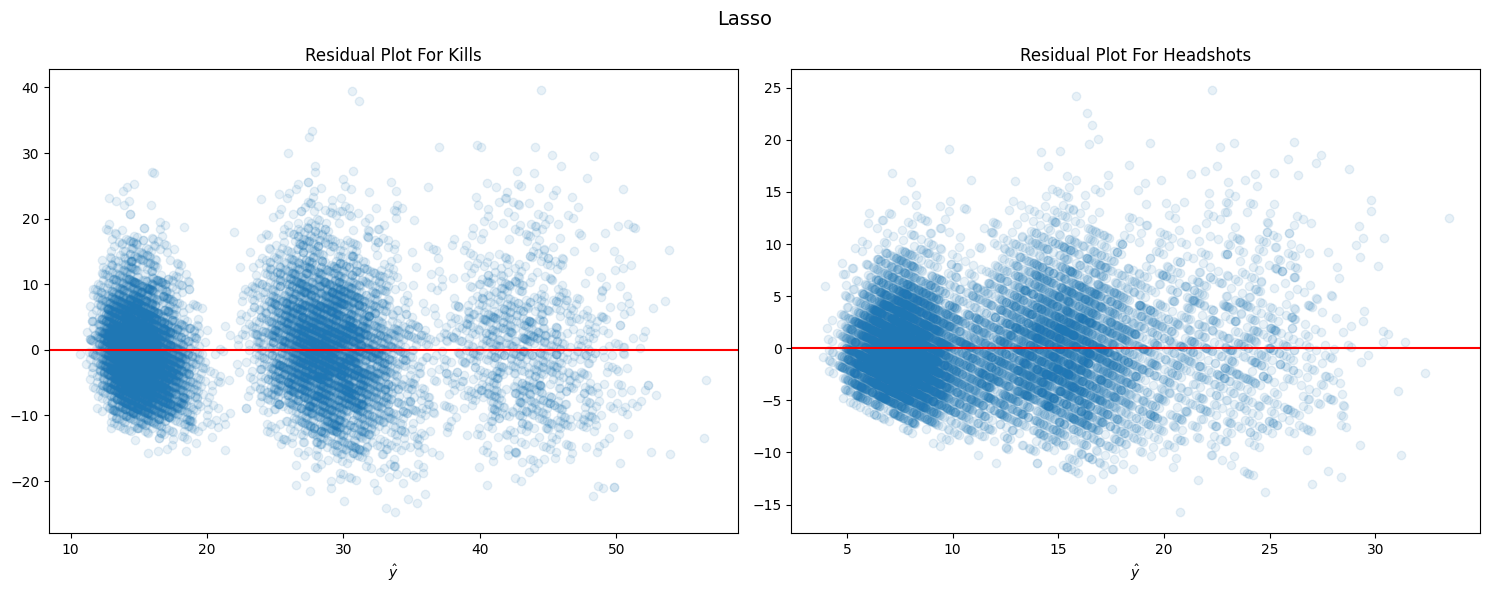

In [31]:
lasso, r2, mae, rmse, y_pred_lasso = model_scores(lasso, x_train, y_train, x_test, y_test)
plot_residuals(y_pred_lasso, y_test, "Lasso")

R2 Score (Kills): 0.6784760355949402
R2 Score (Headshots): 0.6152526140213013
Mean Absolute Error (Kills): 5.2475254233555475
Mean Absolute Error (Headshots): 3.3225282314155447
Root Mean Squared Error (Kills): 6.839112081564859
Root Mean Squared Error (Headshots): 4.323024304826245


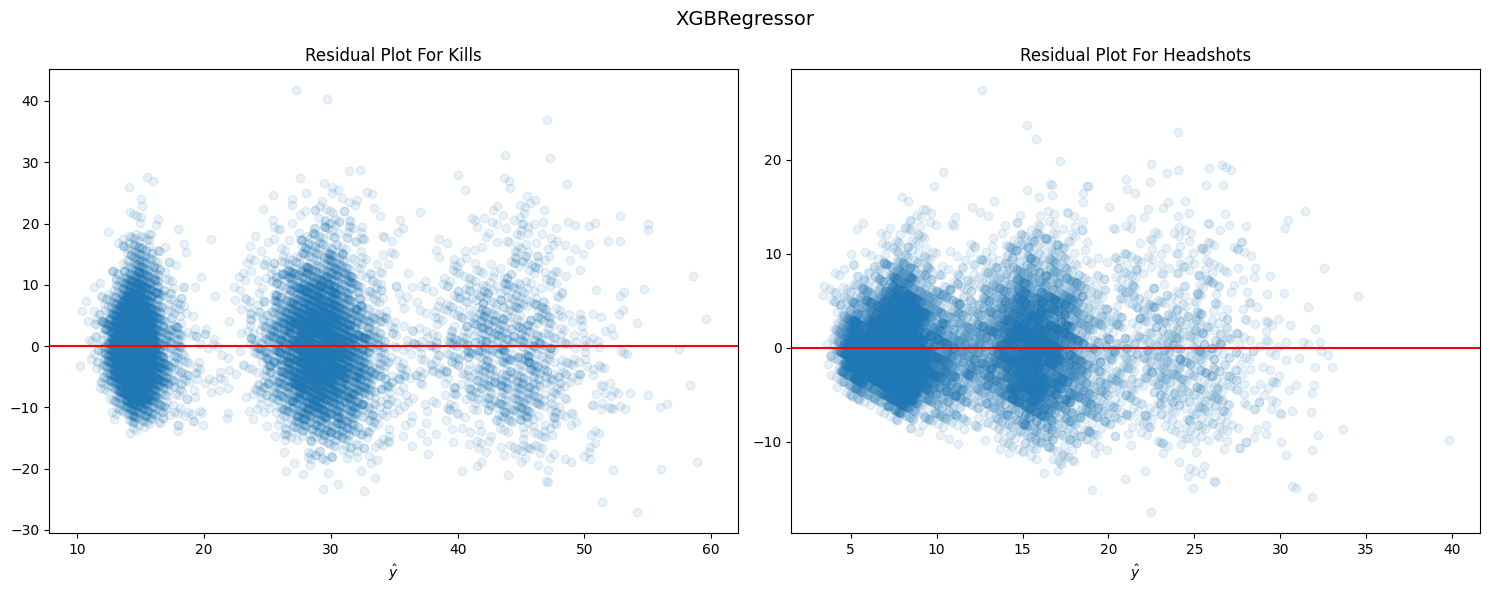

In [32]:
xgr, r2, mae, rmse, y_pred_xgr = model_scores(xgr, x_train, y_train, x_test, y_test)
plot_residuals(y_pred_xgr, y_test, "XGBRegressor")

In [33]:
# Create a dictionary mapping feature importances to feature names
feature_importance_dict = dict(zip(xgr.feature_names_in_, xgr.feature_importances_))

# Sort the features by importance (ascending order)
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

sorted_features

[(np.str_('map_1_3'), np.float32(0.8619802)),
 (np.str_('wma_deaths'), np.float32(0.054688994)),
 (np.str_('map_1_2'), np.float32(0.041529737)),
 (np.str_('wma_headshots'), np.float32(0.018741747)),
 (np.str_('wma_kills'), np.float32(0.013144808)),
 (np.str_('player_enc'), np.float32(0.0016501951)),
 (np.str_('wma_adr'), np.float32(0.0014943787)),
 (np.str_('opponent_team_enc'), np.float32(0.0013747247)),
 (np.str_('player_team_enc'), np.float32(0.0012349385)),
 (np.str_('wma_rating'), np.float32(0.0010233603)),
 (np.str_('wma_assists'), np.float32(0.000963354)),
 (np.str_('wma_kast'), np.float32(0.0009255265)),
 (np.str_('map_1'), np.float32(0.00066783326)),
 (np.str_('map_3'), np.float32(0.00058022345))]

In [34]:
joblib.dump(xgr, "xgr_model_v3.joblib")

['xgr_model_v3.joblib']

In [35]:
# Load the new model
model = joblib.load(fr"C:\Users\kazir\Desktop\Projects\csgo_ml_project\notebooks\xgr_model_v3.joblib")

In [36]:
# Player Map
cursor.execute("SELECT * FROM player_map")
data = cursor.fetchall()
player_hltv_df = pd.DataFrame(data, columns=[col[0] for col in cursor.description])
player_hltv_df.dropna(inplace=True)
player_hltv_df["player_id"] = player_hltv_df["player_id"].astype("int")
player_hltv_df.set_index("player_id", inplace=True)

# Team Map
cursor.execute("SELECT * FROM team_map")
data = cursor.fetchall()
team_hltv_df = pd.DataFrame(data, columns=[col[0] for col in cursor.description])
team_hltv_df.dropna(inplace=True)
team_hltv_df["team_id"] = team_hltv_df["team_id"].astype("int")
team_hltv_df.set_index("team_id", inplace=True)

In [37]:
def make_predictions(team_id, player_id, opponent_team, map_type):
    model_inputs = {
    "wma_kills": None, "wma_headshots": None, "wma_assists": None, "wma_deaths": None, "wma_kast": None, "wma_adr": None,
    "wma_rating": None, "maps_1": 0, "maps_1_2": 0, "maps_1_3": 0, "maps_3": 0, "player_team_enc": None, "opponent_team_enc": None, "player_enc": None
    }
    TEAM_ID = int(team_id)
    PLAYER_ID = int(player_id)
    OPP_TEAM = opponent_team
    MAP_TYPE = map_type

    if ("(Combo)" in map_type) | ("First" in map_type) | ("AWP" in map_type):
        return 0

    kills_or_headshots = MAP_TYPE.split()[-1].lower()
    
    map_number = " ".join(MAP_TYPE.split()[:2])
    map_number_formatted = map_number.lower().replace(" ", "_").replace("-", "_")

    team_url = team_hltv_df.loc[TEAM_ID]["hltv_url"]
    opp_url = team_hltv_df[team_hltv_df["player_team"] == OPP_TEAM]
    # If opponent cannot be found
    if len(opp_url) == 0:
        return 0
    
    opp_url = opp_url["hltv_url"].iloc[0]
    player_url = player_hltv_df.loc[PLAYER_ID]["hltv_url"]

    # ID ERRORS
    try:
        player_team_id = team_mapper.get((team_url, map_number))
    except TypeError:
        print(f"[TEAM ID ERROR]: {TEAM_ID}")
        return 0
    try:
        opp_team_id = team_mapper.get((opp_url, map_number))
    except TypeError:
        print(f"[OPPONENT NAME ERROR]: {OPP_TEAM}")
        return 0
    
    try:
        player_id = player_mapper.get((player_url, map_number))
    except TypeError:
        print(f"[PLAYER ID ERROR]: {PLAYER_ID}")
        return 0
    
    if not(player_team_id and opp_team_id and player_id):
        return 0

    model_inputs["player_team_enc"] = player_team_id
    model_inputs["opponent_team_enc"] = opp_team_id
    model_inputs["player_enc"] = player_id
    model_inputs[map_number_formatted] = 1

    player_data_df = cs_data_formatted[
    (cs_data_formatted["map_number"] == map_number) &
    (cs_data_formatted["player_url"] == player_url)
    ]
    if len(player_data_df) < 8:
        return 0

    dot_product = player_data_df[weight_cols].tail(8).apply(lambda group: np.dot(weights[::-1], group), raw=True)
    kills, headshots, assists, deaths, kast, adr, rating = dot_product
    model_inputs["wma_kills"] = kills
    model_inputs["wma_headshots"] = headshots
    model_inputs["wma_assists"] = assists
    model_inputs["wma_deaths"] = deaths
    model_inputs["wma_kast"] = kast
    model_inputs["wma_adr"] = adr
    model_inputs["wma_rating"] = rating

    x = [np.array(list(model_inputs.values()))]
    prediction = model.predict(x)[0]
    if kills_or_headshots == "headshots":
        return prediction[1]
    else:
        return prediction[0]

In [38]:
prediction_df = pd.DataFrame(prizepicks_lines())
prediction_df.head()

,ID,Game Date,Game Time,Type,Name,Team,Opp,Line Score,Player ID,Team ID
0,3974907,2025-02-27,04:00:00,MAPS 1-2 Kills,dezt,Viperio,Adventurers,28.5,216587,24001
1,3974908,2025-02-27,04:00:00,MAPS 1-2 Kills,Skrimo,Viperio,Adventurers,29.0,194373,24001
2,3974909,2025-02-27,04:00:00,MAPS 1-2 Kills,zodi,Viperio,Adventurers,26.0,194372,24001
3,3974910,2025-02-27,04:00:00,MAPS 1-2 Kills,swicher,Viperio,Adventurers,30.0,216588,24001
4,3974911,2025-02-27,04:00:00,MAPS 1-2 Kills,Junyme,Viperio,Adventurers,31.0,226838,24001


In [39]:
# Predictions
prediction_df["Model Prediction"] = prediction_df.apply(lambda row: make_predictions(team_id=row["Team ID"], player_id=row["Player ID"], opponent_team=row["Opp"], map_type=row["Type"]), axis=1)
prediction_df = prediction_df[prediction_df["Model Prediction"] != 0].drop(columns=["ID", "Player ID", "Team ID"])
prediction_df.reset_index(drop=True)

# Add difference and sort by teams
prediction_df.sort_values(by="Team", inplace=True)
prediction_df["Diff (+/-)"] = prediction_df["Model Prediction"] - prediction_df["Line Score"]
prediction_df["Over/Under"] = np.where(prediction_df["Line Score"] < prediction_df["Model Prediction"], "Over", "Under")

# Save to a CSV
prediction_df.to_csv("predictions.csv", index=False)

# Display
prediction_df.reset_index(drop=True)

,Game Date,Game Time,Type,Name,Team,Opp,Line Score,Model Prediction,Diff (+/-),Over/Under
0,2025-02-27,05:00:00,MAPS 1-2 Headshots,Krad,9 Pandas,Monte,15.5,15.726300,0.226300,Over
1,2025-02-27,05:00:00,MAPS 1-2 Headshots,d1Ledez,9 Pandas,Monte,20.0,19.257553,-0.742447,Under
2,2025-02-27,05:00:00,MAPS 1-2 Headshots,r3salt,9 Pandas,Monte,19.5,15.436245,-4.063755,Under
3,2025-02-27,05:00:00,MAPS 1-2 Kills,Alv,9 Pandas,Monte,31.5,30.744415,-0.755585,Under
4,2025-02-27,05:00:00,MAPS 1-2 Kills,r3salt,9 Pandas,Monte,31.5,28.459713,-3.040287,Under
...,...,...,...,...,...,...,...,...,...,...
125,2025-02-27,08:00:00,MAPS 1-2 Headshots,nEMANHA,Zero Tenacity,Spirit Academy,17.0,18.063316,1.063316,Over
126,2025-02-27,08:00:00,MAPS 1-2 Headshots,brutmonster,Zero Tenacity,Spirit Academy,10.0,9.991790,-0.008210,Under
127,2025-02-27,08:00:00,MAPS 1-2 Headshots,aVN,Zero Tenacity,Spirit Academy,13.5,16.315994,2.815994,Over
128,2025-02-27,08:00:00,MAPS 1-2 Headshots,simke,Zero Tenacity,Spirit Academy,18.5,20.425917,1.925917,Over
